# Identify differentially accessible regions

This tutorial assumes you have read the [Standard Pipeline](https://kzhang.org/SnapATAC2/tutorials/pbmc.html) tutorial and have finished preprocessing, clustering and cell annotations.

In [1]:
import snapatac2 as snap
import numpy as np
import polars as pl

snap.__version__

'2.5.0dev2'

First let's load the previously processed h5ad file.

In [2]:
data = snap.read(snap.datasets.pbmc5k(type="annotated_h5ad"), backed=None)
data

AnnData object with n_obs × n_vars = 4437 × 6062095
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'tsse', 'doublet_probability', 'doublet_score', 'cell_type'
    var: 'count', 'selected'
    uns: 'cell_type_colors', 'doublet_rate', 'frag_size_distr', 'leiden_colors', 'reference_sequences', 'scrublet_sim_doublet_score', 'spectral_eigenvalue'
    obsm: 'X_spectral', 'X_umap', 'fragment_paired'
    obsp: 'distances'

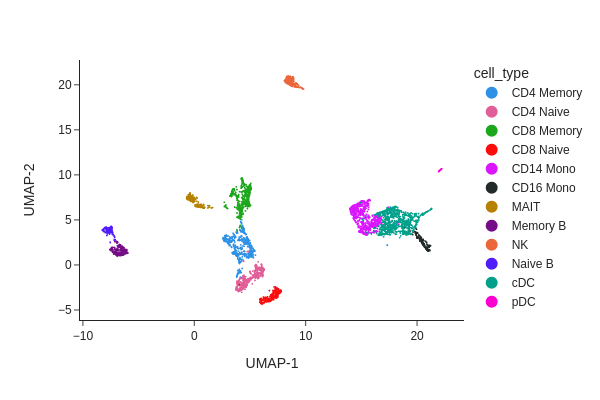

In [3]:
snap.pl.umap(data, color='cell_type', interactive=False)

## Peak calling at the cluster-level

An important goal of single-cell ATAC-seq analysis is to identify genomic regions that are enriched with TN5 insertions, or “open chromatin” regions. Using [tl.macs3()](../api/_autosummary/snapatac2.tl.macs3.html#snapatac2.tl.macs3), we can easily identify "peaks" or open chromatin regions in different cell populations.

In the example below, we group the cells according to the "cell_type" label and then call peaks in each cell type. If you have replicate information and want to identify reproducible peaks across replicates, you can do this by specifying the `replicate` parameter.

In [4]:
%%time
snap.tl.macs3(data, groupby='cell_type')

2023-10-09 08:39:03 - INFO - Exporting fragments...
2023-10-09 08:39:59 - INFO - Calling peaks...
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [02:58<00:00, 14.84s/it]

CPU times: user 4min 30s, sys: 3.7 s, total: 4min 34s
Wall time: 3min 54s


The result of this step is stored in `data.uns['macs3']` as a dictionary, where keys correspond to cell type labels, and values are identified peaks stored as a dataframe object.

The peaks called by MACS3 are usually with different length and peaks from different cell types may overlap. To facilitate the downstream analysis, a unified, non-overlapping, and fixed-width peak list is uaually desired. This can be acheived by the [tl.merge_peaks()](../api/_autosummary/snapatac2.tl.merge_peaks.html#snapatac2.tl.merge_peaks) function.

In [5]:
%%time
peaks = snap.tl.merge_peaks(data.uns['macs3'], snap.genome.hg38)
peaks.head()

CPU times: user 1.81 s, sys: 36.9 ms, total: 1.85 s
Wall time: 1.85 s


Peaks,cDC,NK,CD4 Memory,CD4 Naive,CD16 Mono,CD8 Memory,CD14 Mono,CD8 Naive,MAIT,pDC,Memory B,Naive B
str,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool
"""chr1:180610-18…",true,true,true,false,true,true,true,false,false,false,false,false
"""chr1:181226-18…",false,false,true,true,false,true,false,false,true,false,false,false
"""chr1:191568-19…",true,true,false,false,false,true,true,false,true,false,false,false
"""chr1:267716-26…",true,false,true,false,true,true,true,true,true,false,false,true
"""chr1:280549-28…",true,false,false,false,false,false,false,false,false,false,false,false


Now, with the peak list, we can create a cell by peak matrix by `snap.pp.make_peak_matrix`.

In [6]:
%%time
peak_mat = snap.pp.make_peak_matrix(data, use_rep=peaks['Peaks'])
peak_mat

CPU times: user 1min 6s, sys: 1.91 s, total: 1min 7s
Wall time: 10.3 s


AnnData object with n_obs × n_vars = 4437 × 302197
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'tsse', 'doublet_probability', 'doublet_score', 'cell_type'

Finding marker regions
---------------------------

In this section, we are going to use a quick-and-dirty method to identify marker regions for each cell type. The `tl.marker_regions` function aggregates signal across cells and utilizes z-scores to identify specifically enriched peaks.

In [7]:
%%time
marker_peaks = snap.tl.marker_regions(peak_mat, groupby='cell_type', pvalue=0.01)

CPU times: user 3.73 s, sys: 116 ms, total: 3.85 s
Wall time: 3.87 s


2023-10-09 08:43:13 - WARNING - Input contains 121900 peaks, only 50000 peaks will be plotted.


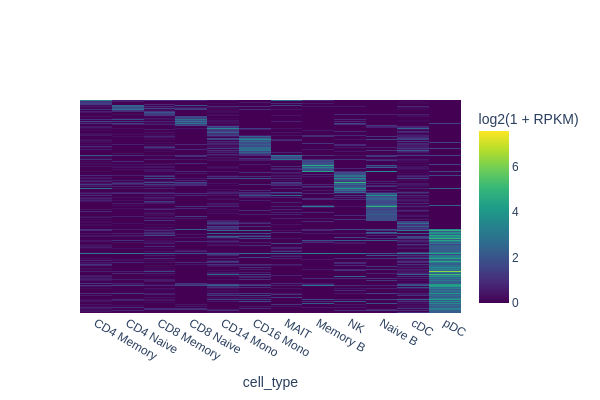

In [8]:
snap.pl.regions(peak_mat, groupby='cell_type', peaks=marker_peaks, interactive=False)

In [9]:
%%time
motifs = snap.tl.motif_enrichment(
    motifs=snap.datasets.cis_bp(unique=True),
    regions=marker_peaks,
    genome_fasta=snap.genome.hg38,
)

2023-10-09 08:43:19 - INFO - Fetching 121900 sequences ...
2023-10-09 08:43:38 - INFO - Computing enrichment ...
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1165/1165 [25:06<00:00,  1.29s/it]

CPU times: user 3h 6min 33s, sys: 25.3 s, total: 3h 6min 59s
Wall time: 25min 25s


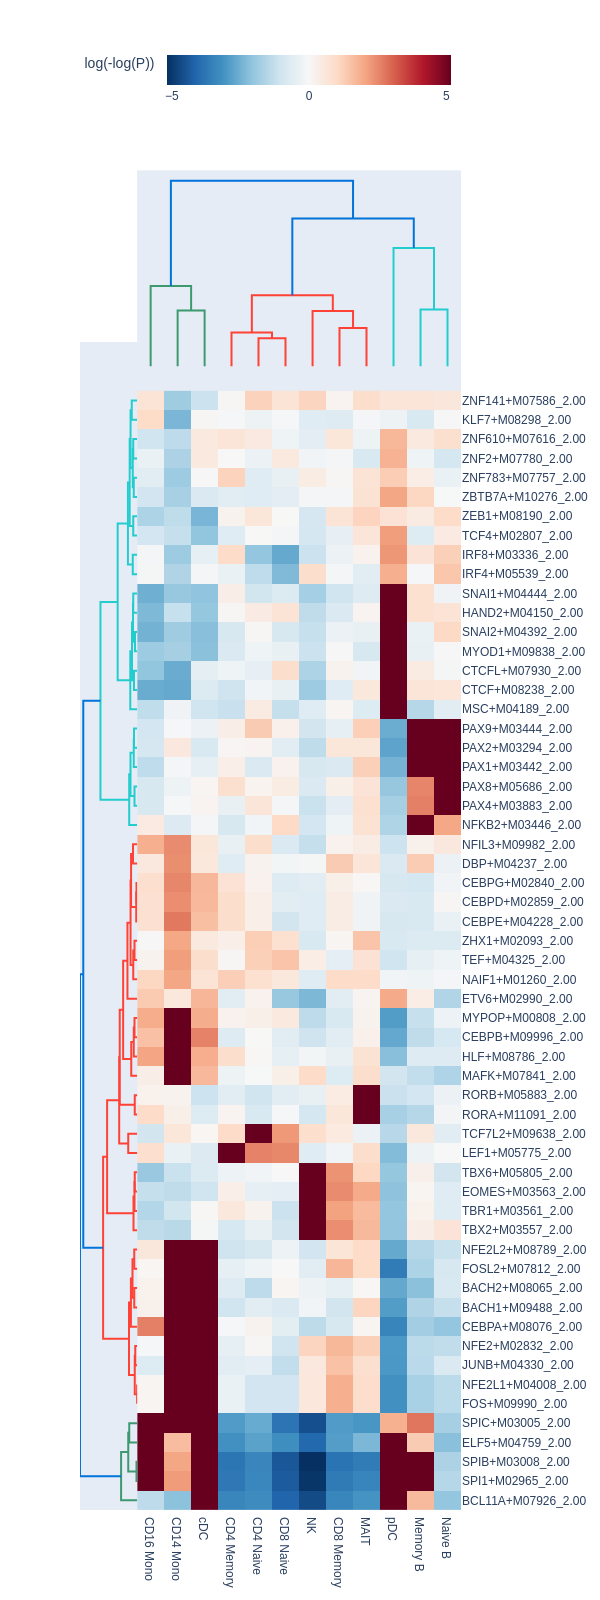

In [10]:
snap.pl.motif_enrichment(motifs, max_fdr=0.0001, height=1600, interactive=False)

## Regression-based differential test


The `tl.marker_regions` above does not consider the variations across cells. To fully utilize the single-cell information, we can apply regression-based differential test method. First, Let's select the peaks that are either present in naive B cells or memory B cells.

In [11]:
group1 = "Naive B"
group2 = "Memory B"
naive_B = data.obs['cell_type'] == group1
memory_B = data.obs['cell_type'] == group2
peaks_selected = np.logical_or(
    peaks[group1].to_numpy(),
    peaks[group2].to_numpy(),
)

Perform differential test using `tl.diff_test`.

In [12]:
%%time
diff_peaks = snap.tl.diff_test(
    peak_mat,
    cell_group1=naive_B,
    cell_group2=memory_B,
    features=peaks_selected,
)

2023-10-09 09:08:48 - INFO - Input contains 109236 features, now perform filtering with 'min_log_fc = 0.25' and 'min_pct = 0.05' ...
2023-10-09 09:09:02 - INFO - Testing 30674 features ...
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30674/30674 [04:31<00:00, 113.06it/s]


CPU times: user 4min 34s, sys: 2.15 s, total: 4min 36s
Wall time: 4min 45s


Filter the results based on adjusted p-value or FDR.

In [13]:
diff_peaks = diff_peaks.filter(pl.col('adjusted p-value') < 0.01)
diff_peaks.head()

feature name,log2(fold_change),p-value,adjusted p-value
str,f64,f64,f64
"""chr17:3558486-…",6.366254,6.2907e-30,1.9296e-25
"""chr5:156402578…",4.45287,4.2096e-24,6.4563e-20
"""chr6:52497613-…",5.425494,3.6230e-22,3.7044e-18
"""chr4:155758707…",-2.975222,6.8747e-21,5.2718e-17
"""chr1:15949522-…",4.184897,1.7255e-19,1.0586e-15


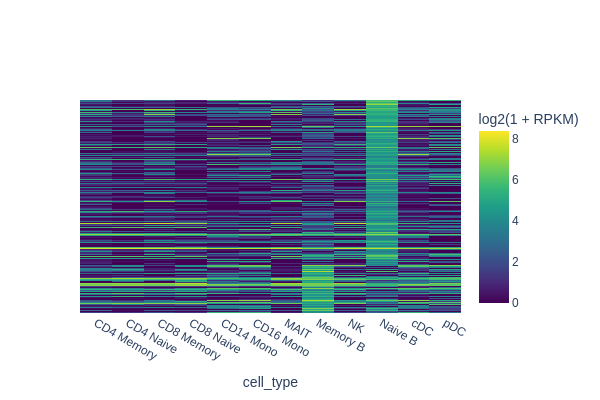

In [14]:
snap.pl.regions(
    peak_mat,
    groupby = 'cell_type',
    peaks = {
        group1: diff_peaks.filter(pl.col("log2(fold_change)") > 0)['feature name'].to_numpy(),
        group2: diff_peaks.filter(pl.col("log2(fold_change)") < 0)['feature name'].to_numpy(),
    },
    interactive = False,
)

In the next example we are going to identify peaks that are accessible in memory B cells but not in the rest of cells. One way of doing this is to select random cells from each cluster to form the background, and then perform test between memory B cells and the background.

Here we randomly select 30 cells from other cell clusters, and set the `direction = "positive"` because we are interested in peaks that are more accessible in memory B cells.

In [15]:
barcodes = np.array(data.obs_names)
background = []
for i in np.unique(data.obs['cell_type']):
    if i != group2:
        cells = np.random.choice(barcodes[data.obs['cell_type'] == i], size=30, replace=False)
        background.append(cells)
background = np.concatenate(background)

In [16]:
diff_peaks = snap.tl.diff_test(
    peak_mat,
    cell_group1=memory_B,
    cell_group2=background,
    features=peaks[group2].to_numpy(),
    direction="positive",
)

2023-10-09 09:13:38 - INFO - Input contains 80101 features, now perform filtering with 'min_log_fc = 0.25' and 'min_pct = 0.05' ...
2023-10-09 09:13:49 - INFO - Testing 18102 features ...
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18102/18102 [02:43<00:00, 110.74it/s]


In [17]:
diff_peaks = diff_peaks.filter(pl.col('adjusted p-value') < 0.01)
diff_peaks.head()

feature name,log2(fold_change),p-value,adjusted p-value
str,f64,f64,f64
"""chr14:10581789…",5.764083,7.5437e-61,1.3656e-56
"""chr11:95715787…",4.770199,3.8932e-54,3.5237e-50
"""chr16:17301605…",3.580612,7.4821e-46,3.4825e-42
"""chr9:37409024-…",3.453806,7.6952e-46,3.4825e-42
"""chr11:60455435…",3.39517,6.2943e-44,2.2788e-40


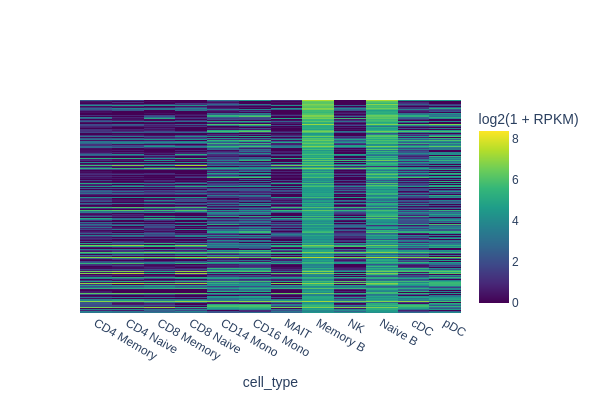

In [18]:
snap.pl.regions(
    peak_mat,
    groupby='cell_type',
    peaks={ group2: diff_peaks['feature name'].to_numpy() },
    interactive=False,
)

It's important to note that we compared memory B cells with all other cell types. Thus, it's not necessary to distinguish the differences between memory B and naive B cells specifically. As depicted in the plot, peaks specific to both naive and memory B cells were identified in this analysis. Therefore, designing a robust background control is crucial for differential analysis.